# TensorFlow Probability Interface

In [1]:
%load_ext lab_black

In [29]:
import gpjax
import gpjax.core as gpx
import gpviz as gpv
import jax.numpy as jnp
import jax.random as jr
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from jax import grad, jit

tfd = tfp.distributions
key = jr.PRNGKey(123)
plt.style.use(gpv.__stylesheet__)

## Simulate some data

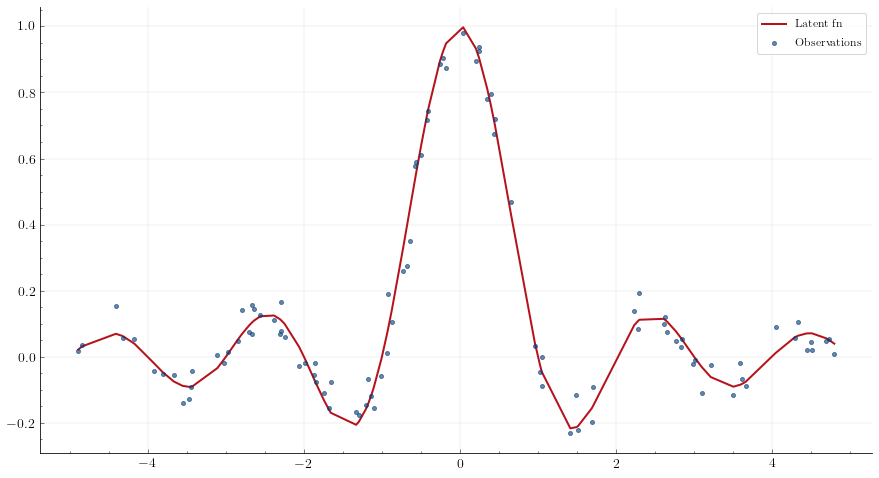

In [30]:
x = jnp.sort(jr.uniform(key, minval=-5.0, maxval=5.0, shape=(100, 1)), axis=0)
f = lambda x: jnp.sin(jnp.pi * x) / (jnp.pi * x)
y = f(x) + jr.normal(key, shape=x.shape) * 0.05
plt.plot(x, f(x), label="Latent fn")
plt.plot(x, y, "o", label="Observations", alpha=0.6)
plt.legend(loc="best")

In [31]:
training = gpx.Dataset(X=x, y=y)

## Define GP

In [32]:
prior = gpx.Prior(kernel=gpx.RBF())
posterior = prior * gpx.Gaussian()
print(posterior)

Conjugate Posterior
--------------------------------------------------------------------------------
- Zero mean function
	 Output dimension: 1
- Radial basis function kernel:
	 Stationary: True
	 Spectral form: False 
	 ARD structure: False
- Gaussian likelihood function


## Initialise parameters

All parameters in this model are constrained to be positive. The softplus transformation will be applied to them to map them onto the entire real line.

In [33]:
params = gpx.initialise(posterior)
configs = gpx.get_defaults()
constrainer, unconstrainer = gpx.build_all_transforms(params.keys(), configs)
params = unconstrainer(params)

## State priors

We'll also place prior distributions on the constrained value of each of our three parameters.

In [34]:
priors = {
    "lengthscale": tfd.Gamma(1.0, 1.0),
    "variance": tfd.Gamma(2.0, 2.0),
    "obs_noise": tfd.Gamma(2.0, 2.0),
}

## Define target distribution

The marginal log-likelihood distribution can now be computed from the above GP posterior.

In [35]:
mll = gpx.marginal_ll(posterior, transform=constrainer, negative=False)

### Check the MLL

In [36]:
mll(params, training, priors)

DeviceArray(-105.28926949, dtype=float64)

In [17]:
grad(mll)(params, training, priors)

{'lengthscale': DeviceArray([1.3475098], dtype=float64),
 'obs_noise': DeviceArray([-29.3289119], dtype=float64),
 'variance': DeviceArray([-2.78458137], dtype=float64)}

## Setup TFP HMC sampler

To allow our MLL function to accept a Jax array as input, not a set of parameters, we'll define a quick helper function to make an arbitary array to our parameter dictionary.

In [18]:
from typing import List


def array_to_dict(varray: jnp.DeviceArray, keys: List):
    pdict = {}
    for val, key in zip(varray, keys):
        pdict[key] = val
    return pdict

We'll also fix all our marginal log-likelihood's arguments except the parameters input.

In [19]:
from functools import partial

target_dist = partial(mll, training=training, priors=priors)

In [20]:
def build_log_pi(params, target_fn):
    param_keys = list(params.keys())

    def target(params: jnp.DeviceArray):
        coerced_params = array_to_dict(params, param_keys)
        return target_fn(coerced_params)

    return target

In [21]:
log_pi = build_log_pi(params, target_dist)

So now we have a functional representation of our GP posterior's marginal log-likelihood that accepts a single Jax array as input. It's worthwhile here checking that evaluation of our new function agrees with our initial marginal log-likelihood function.

In [22]:
initial_params = jnp.array(list(params.values())).squeeze()
print(initial_params)

[0.54132485 0.54132485 0.54132485]


In [23]:
assert log_pi(initial_params) == mll(params, training, priors)

With both the marginal log-likelihood and its respective gradient functions in agreeance, we can go ahead and instantiate the TFP HMC sampler. In the interest of time, we'll just sample 500 times from out targer distribution. However, in practice, you'll want to sample for longer.

In [24]:
def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(log_pi, 1e-1)
    return tfp.mcmc.sample_chain(
        500,
        current_state=state,
        kernel=kernel,
        trace_fn=lambda _, results: results.target_log_prob,
        seed=key,
    )

In [25]:
states, log_probs = jit(run_chain)(key, initial_params)

In [26]:
states

DeviceArray([[ 0.62972628,  0.45466263,  0.36770161],
             [ 0.54588315, -0.03068447,  0.18910682],
             [ 0.67626365, -0.45411678,  0.37432919],
             ...,
             [ 0.16355066, -6.39076017, -2.01724769],
             [ 0.35154267, -6.34581552, -0.89997935],
             [ 0.15834599, -6.32055129, -2.03701745]], dtype=float64)

In [37]:
constrained_states = jnp.hstack(
    (
        i.reshape(-1, 1)
        for i in constrainer(array_to_dict(states.T, params.keys())).values()
    )
)

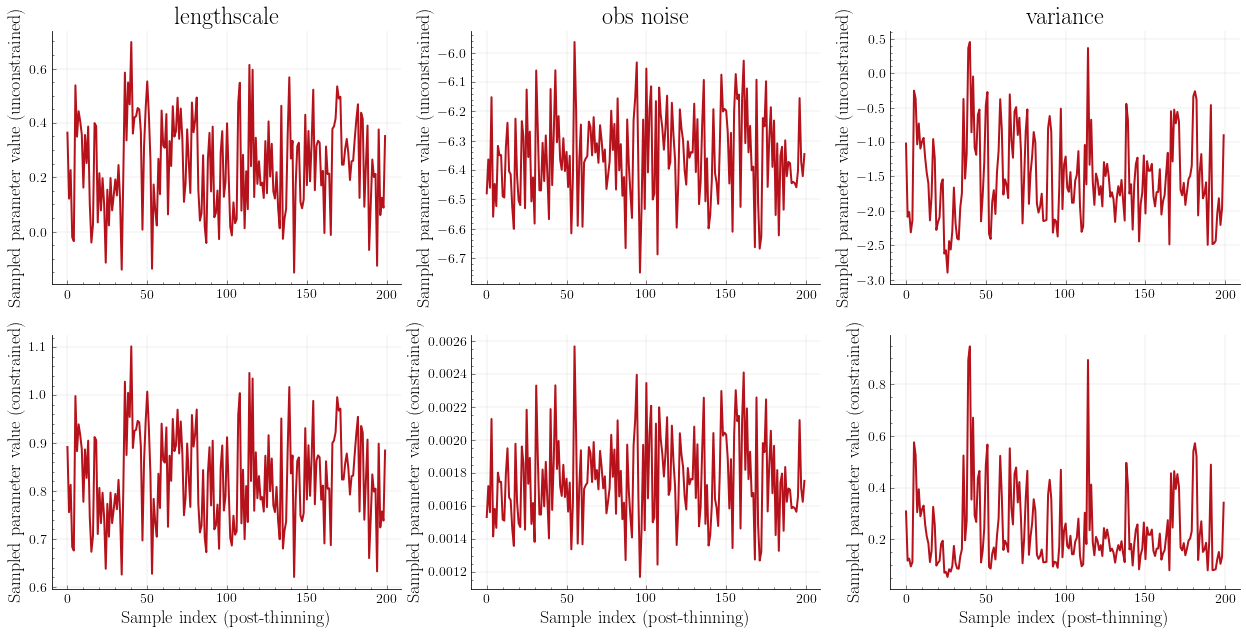

In [39]:
burn_in = 100
thin_factor = 2
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

for i, p, pc, t in zip(range(3), states.T, constrained_states.T, params.keys()):
    ax[0][i].plot(p[burn_in:][::thin_factor])
    ax[0][i].set_title(t.replace("_", " "))
    ax[0][i].set_ylabel("Sampled parameter value (unconstrained)")
    ax[1][i].plot(pc[burn_in:][::thin_factor])
    ax[1][i].set_xlabel("Sample index (post-thinning)")
    ax[1][i].set_ylabel("Sampled parameter value (constrained)")

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder"

gpjax                                 0.3.8
tensorflow_probability.substrates.jax 0.12.0-dev20201123
gpviz                                 0.0.4
Thomas Pinder 
last updated: Wed May 12 2021 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2
